In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

###Prepare the Dataset

In [2]:
# Load 20 newsgroups dataset
categories = ['comp.sys.ibm.pc.hardware', 'misc.forsale','rec.sport.hockey','talk.politics.guns','sci.med','talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='all', categories=categories,remove=('headers', 'footers', 'quotes'))
texts, labels = newsgroups.data, newsgroups.target

In [102]:
newsgroups.target_names

['comp.sys.ibm.pc.hardware',
 'misc.forsale',
 'rec.sport.hockey',
 'sci.med',
 'talk.politics.guns',
 'talk.religion.misc']

In [4]:
tokens = [simple_preprocess(text) for text in texts]

In [6]:
# Create a word to index mapping based on GloVe
# [word->vector] to {word->index} and [vector]

glove_txt_path = '/content/drive/MyDrive/Glove Embeddings/glove.6B.100d.txt'
word2idx = {}
vectors = []
with open(glove_txt_path, 'r', encoding='utf-8') as f:
    for idx, line in enumerate(f):
        values = line.split()
        word = values[0]
        vector = list(map(float, values[1:]))
        word2idx[word] = idx
        vectors.append(vector)

In [7]:
vectors = torch.tensor(vectors)
embedding_dim = vectors.shape[1]

In [8]:
# convert documents to indices
def doc2ind(doc):
  return [word2idx.get(word,0) for word in doc] #

In [9]:
# Convert documents to indices
ng_vector_idx = [doc2ind(doc) for doc in tokens]

In [10]:
max(len(doc) for doc in ng_vector_idx)

9516

In [11]:
# Getting docs with non-zero number of tokens and their labels
non_zero_ng_vector_idx = []
non_zero_labels = []

for i in range(len(ng_vector_idx)):
  if len(ng_vector_idx[i]) != 0:
    non_zero_ng_vector_idx.append(ng_vector_idx[i])
    non_zero_labels.append(labels[i])

In [12]:
lengths = []
for d in non_zero_ng_vector_idx:
  lengths.append(len(d))
lengths.sort()

In [13]:
import numpy as np
data = np.array(lengths)
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
quartiles = np.percentile(data, [75,95])
mean,median,std_dev,quartiles

(155.6969696969697, 79.0, 348.8732783750864, array([154.75, 494.5 ]))

In [14]:
# Removing docs with number of tokens more than 500 and their labels
cleaned_ng_vector_idx = []
cleaned_labels = []

for i in range(len(non_zero_ng_vector_idx)):
  if len(non_zero_ng_vector_idx[i]) <= 700:
    cleaned_ng_vector_idx.append(non_zero_ng_vector_idx[i])
    cleaned_labels.append(non_zero_labels[i])

In [15]:
# percent of data removed
print(((len(ng_vector_idx) - len(cleaned_ng_vector_idx)) / len(ng_vector_idx) )*100)

# length of data
print(len(cleaned_ng_vector_idx))

5.178701677607585
5200


In [16]:
max_len = max(len(doc) for doc in cleaned_ng_vector_idx)

In [64]:
max_len

695

In [17]:
padded_ng_vector_idx = torch.tensor([doc + [0] * (max_len - len(doc)) for doc in cleaned_ng_vector_idx])

In [18]:
labels = torch.tensor(cleaned_labels)

In [19]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_ng_vector_idx, labels, test_size=0.2, random_state=42)

##Neural Network

In [20]:
# Define custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [21]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Neural Network Model
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class TextClassificationModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes, pretrained_embeddings):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

num_classes = 6
model = TextClassificationModel(len(word2idx), embedding_dim, num_classes, vectors)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
embeddings_before = model.embedding.weight.data

##Training

In [24]:
torch.manual_seed(42)
num_epochs = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  train_correct = 0
  train_total = 0

  for texts, labels in train_loader:
    texts, labels = texts.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(texts)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()


  ### Testing
  model.eval()
  total = 0
  correct = 0
  with torch.inference_mode():
    for texts, labels in test_loader:
      texts, labels = texts.to(device), labels.to(device)
      outputs = model(texts)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100 * train_correct / train_total

  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/40], Train Loss: 1.7831, Train Accuracy: 19.28%, Test Accuracy: 18.75%
Epoch [2/40], Train Loss: 1.7760, Train Accuracy: 23.25%, Test Accuracy: 23.27%
Epoch [3/40], Train Loss: 1.7676, Train Accuracy: 25.91%, Test Accuracy: 28.65%
Epoch [4/40], Train Loss: 1.7551, Train Accuracy: 31.83%, Test Accuracy: 31.63%
Epoch [5/40], Train Loss: 1.7386, Train Accuracy: 36.90%, Test Accuracy: 32.98%
Epoch [6/40], Train Loss: 1.7191, Train Accuracy: 37.81%, Test Accuracy: 35.00%
Epoch [7/40], Train Loss: 1.6975, Train Accuracy: 42.64%, Test Accuracy: 39.52%
Epoch [8/40], Train Loss: 1.6747, Train Accuracy: 44.76%, Test Accuracy: 46.06%
Epoch [9/40], Train Loss: 1.6493, Train Accuracy: 49.11%, Test Accuracy: 47.31%
Epoch [10/40], Train Loss: 1.6242, Train Accuracy: 53.41%, Test Accuracy: 47.98%
Epoch [11/40], Train Loss: 1.5993, Train Accuracy: 55.50%, Test Accuracy: 55.87%
Epoch [12/40], Train Loss: 1.5752, Train Accuracy: 59.83%, Test Accuracy: 58.65%
Epoch [13/40], Train Loss: 1.5520, Tr

In [25]:
model.to('cpu')
embeddings_after = model.embedding.weight.data

In [44]:
glove_emb_before = nn.Embedding.from_pretrained(embeddings_before)
glove_emb_after = nn.Embedding.from_pretrained(embeddings_after)

##Visualize Embeddings

In [89]:
random_indices = np.random.choice(padded_ng_vector_idx.shape[0], 100, replace=False)

docs_emb_before = []
docs_emb_after = []
lbls = np.array(cleaned_labels)
doc_labels = lbls[random_indices]

for i in random_indices:
  doc_emb_before = glove_emb_before(torch.tensor(padded_ng_vector_idx[i])).flatten()
  doc_emb_after = glove_emb_after(torch.tensor(padded_ng_vector_idx[i])).flatten()

  docs_emb_before.append(doc_emb_before)
  docs_emb_after.append(doc_emb_after)

In [95]:
docs_emb_after = np.array(docs_emb_after)
docs_emb_before = np.array(docs_emb_before)

In [101]:
docs_emb_before.shape

(100, 69500)

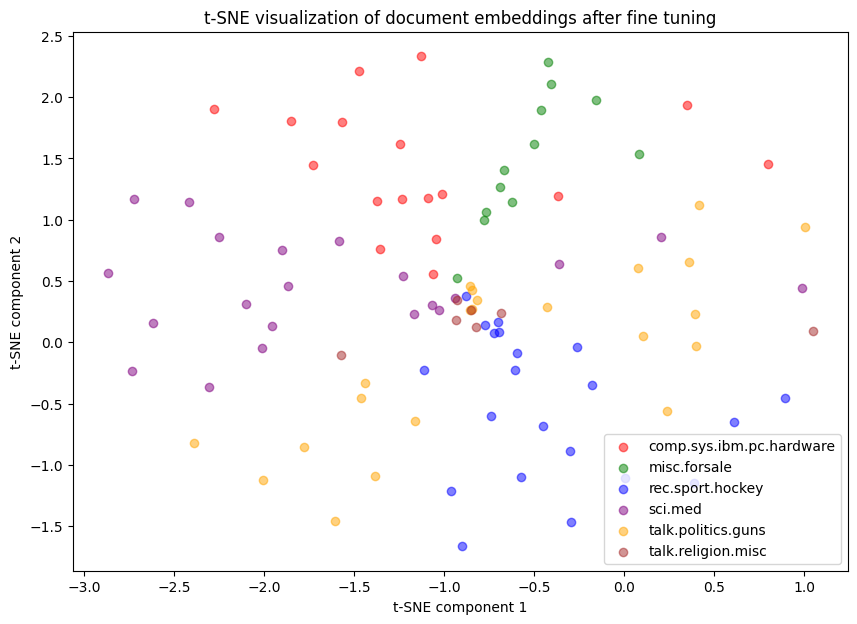

In [107]:
tsne = TSNE(n_components=2, random_state=42)

docs_emb_after_reduced = tsne.fit_transform(docs_emb_after)

# Define the labels and their corresponding colors
labels = ['comp.sys.ibm.pc.hardware', 'misc.forsale', 'rec.sport.hockey', 'sci.med', 'talk.politics.guns', 'talk.religion.misc']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']

# Plot the t-SNE reduced embeddings
plt.figure(figsize=(10, 7))
for i in range(len(labels)):
    indices = np.where(doc_labels == i)
    plt.scatter(docs_emb_after_reduced[indices, 0], docs_emb_after_reduced[indices, 1], c=colors[i], label=labels[i], alpha=0.5)

plt.title('t-SNE visualization of document embeddings after fine tuning')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()


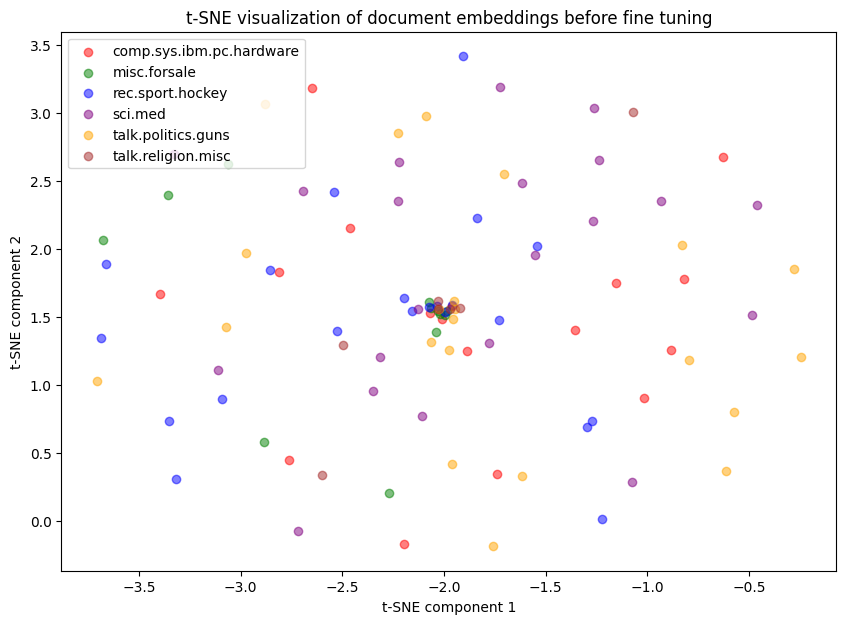

In [108]:
tsne = TSNE(n_components=2, random_state=42)

docs_emb_before_reduced = tsne.fit_transform(docs_emb_before)

# Define the labels and their corresponding colors
labels = ['comp.sys.ibm.pc.hardware', 'misc.forsale', 'rec.sport.hockey', 'sci.med', 'talk.politics.guns', 'talk.religion.misc']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']

# Plot the t-SNE reduced embeddings
plt.figure(figsize=(10, 7))
for i in range(len(labels)):
    indices = np.where(doc_labels == i)
    plt.scatter(docs_emb_before_reduced[indices, 0], docs_emb_before_reduced[indices, 1], c=colors[i], label=labels[i], alpha=0.5)

plt.title('t-SNE visualization of document embeddings before fine tuning')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()
